In [7]:
import scanpy as sc 
import matplotlib.pyplot as plt
import os
import seaborn as sns
import numpy as np
from scipy import stats
os.system("clear")

###############
dataset="human_pancreas_norm_complexBatch"
ncluster=14
###############

data_dir="/home/ubuntu/benchmarking/"+dataset+".h5ad"
adata=sc.read(data_dir)
print(adata)
adata.obs['batch'] = adata.obs.tech
# print_dataset_information(adata_raw,batch_key="BATCH",celltype_key="celltype")

AnnData object with n_obs × n_vars = 16382 × 19093
    obs: 'tech', 'celltype', 'size_factors'
    layers: 'counts'


##  Data Cleaning

comment: Looks like the data in human_pancreas_norm_complexBatch.h5ad is already preprocessed in some way since numbers are not integers

In [8]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.var["mt"] = adata.var_names.str.startswith("mt-")

In [9]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 16382 × 19093
    obs: 'tech', 'celltype', 'size_factors', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts'

/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


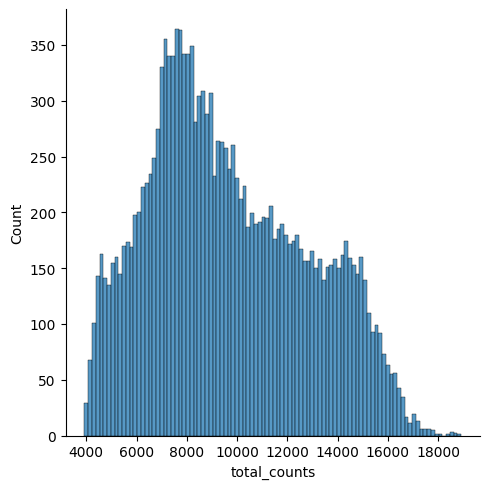

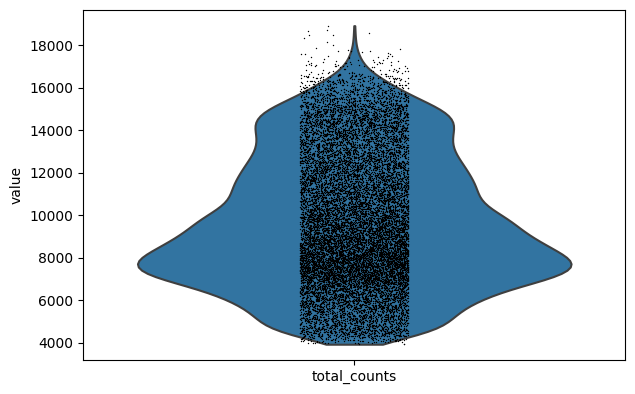

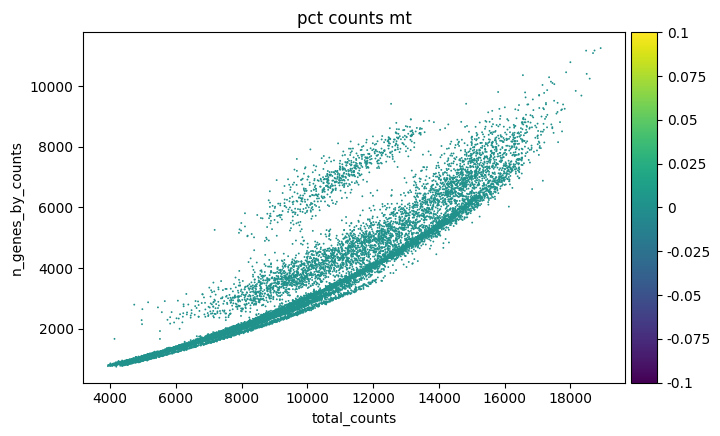

In [11]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
sc.pl.violin(adata, 'total_counts')
# p2 = sc.pl.violin(adata, "pct_counts_mt")
# p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [20]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * stats.median_abs_deviation(M)) | (
        np.median(M) + nmads * stats.median_abs_deviation(M) < M
    )
    return outlier

In [21]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
)
adata.obs.outlier.value_counts()

False    16273
True       109
Name: outlier, dtype: int64

In [22]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[~adata.obs.outlier].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 16382
Number of cells after filtering of low quality cells: 16273


/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


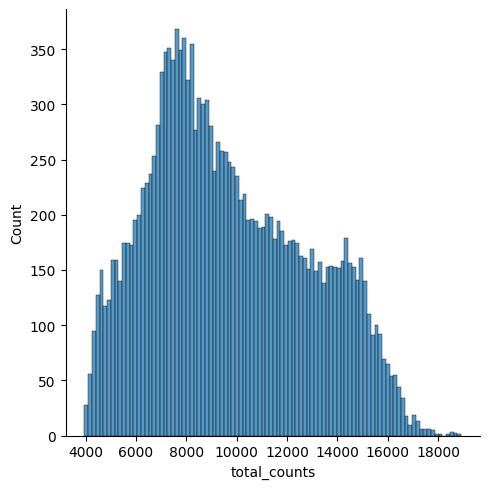

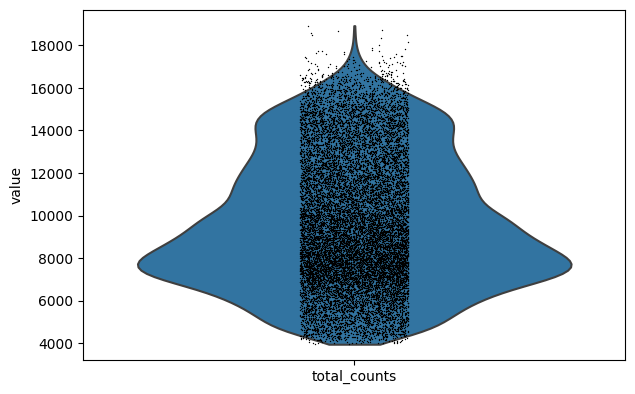

In [24]:
p1 = sns.displot(adata.obs["total_counts"], bins=100, kde=False)
sc.pl.violin(adata, 'total_counts')
# p2 = sc.pl.violin(adata, "pct_counts_mt")
# p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

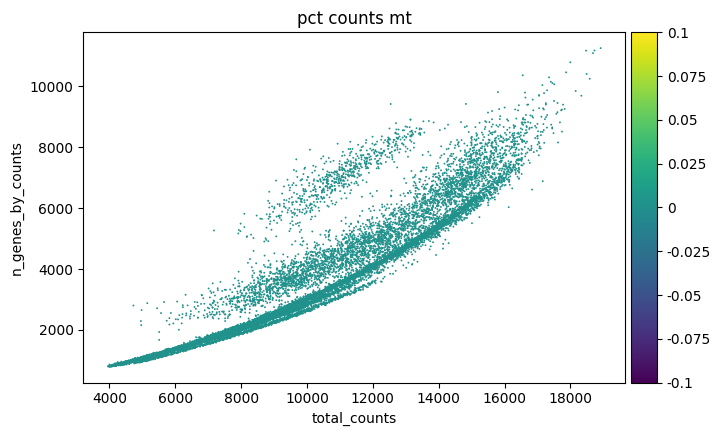

In [25]:
p1 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [26]:
print(f"Total number of genes: {adata.n_vars}")

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=20)
print(f"Number of genes after cell filter: {adata.n_vars}")

Total number of genes: 19093
Number of genes after cell filter: 16851


In [27]:
# Preliminary clustering for differentiated normalisation
adata_pp = adata.copy()
sc.pp.normalize_total(adata_pp)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="groups")

/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/umap/distances.py:

In [29]:
adata_pp.X.max()

3.3115115

/home/ubuntu/benchmarking_venv/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


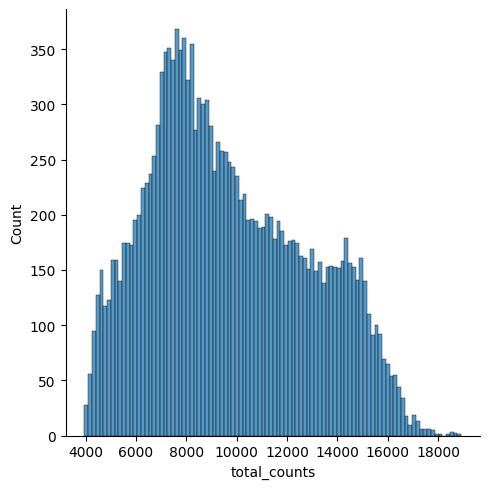

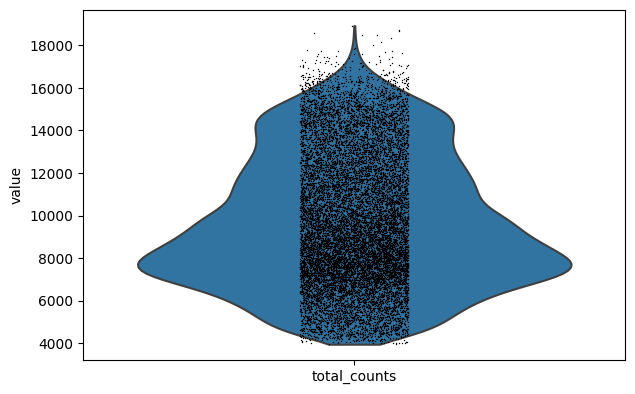

In [28]:
p1 = sns.displot(adata_pp.obs["total_counts"], bins=100, kde=False)
sc.pl.violin(adata_pp, 'total_counts')
# p2 = sc.pl.violin(adata, "pct_counts_mt")
# p3 = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")